# Importing

## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, adagrad, rmsprop


Using TensorFlow backend.


## importing own code

In [2]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

In [3]:
def trainNetwork(network, trainingData, validationSplit, numberOfEpochs=50, batchSize=32, verboseSetting=-1):
    """
    hjhgj
    
    network is the Keras network to be trained.
    trainingData is the data to be trained with. It is a tupple with the index zero being the input data and index one being the target/output value.
    validationData is the data used to do validation.  It is a tupple with the index zero being the input data and index one being the target/output value.
    numberOfEpochs is the number of epochs the model will train for default is 50.
    batchSize is the size of the batches during gradiant decent defaul is 32.
    verboseSettings are the verbose settings default is -1 (which does nothing), 0 results in plots and above that normal rules apply.
    """
    
    #print(np.shape(trainingData[0]))
    #print(np.shape(trainingData[0][0]))
    #print(np.shape(trainingData[1]))
    
    #print(trainingData[0])
    
    fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))
    
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    if verboseSetting>=0:
        
        maximumValue = max(max(history['loss']), max(history['val_loss']))
        minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax1.legend()
        ax1.set_xlim(1, numberOfEpochs)
        ax1.set_ylim(0, maximumValue)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss (training and validation) vs the number of epochs.')
        
        ax2.plot(history['loss'], history['val_loss'])
        ax2.set_xlim(0, maximumValue)
        ax2.set_ylim(0, maximumValue)
        ax2.set_xlabel('Training loss')
        ax2.set_ylabel('Validation loss')
        ax2.set_title('Validation loss vs training loss.')
        
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax3.legend()
        ax3.set_xlim(1, numberOfEpochs)
        ax3.set_yscale('log')
        ax3.set_ylim(minimumValue, maximumValue)
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Loss')
        ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
        
        ax4.plot(history['loss'], history['val_loss'])
        ax4.set_xscale('log')
        ax4.set_xlim(minimumValue, maximumValue)
        ax4.set_yscale('log')
        ax4.set_ylim(minimumValue, maximumValue)
        ax4.set_xlabel('Training loss')
        ax4.set_ylabel('Validation loss')
        ax4.set_title('Validation loss vs training loss (logarithmic).')
        
        math.pow(math.log(min(min(history['loss']), min(history['val_loss'])), 10), 10)
        
        plt.show()
        history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [4]:
def makePredictionPlot(model, dataFrame, amountOfPoints=1000):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy')
    ax1.set_ylabel('Predicted energy')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()
    

In [5]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    fig, ax = plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)
    return fig, ax

In [6]:
def makeNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MSE'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3]))#, kernel_initializer=kernalInitializer))#, kernel_initializer=kernalInitializer))
    model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        if setting[0]=='Dense':# 1 is amount of nodes, 2 is kind of activation, 3 is bias
            model.add(Dense(setting[1], use_bias=setting[3]))#, kernel_initializer=kernalInitializer))
            model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)#mse or mape
    
    return model

# Getting data

In [7]:
filename = 'databaseModLen_min_cut0.90_widths86_Width1.5-10_data50k_3-1sur_epoch30_maxDelta0.1_R020_M2M3M4M5Prepared'#'OLDcombinedDataR100M2M3M4Prepared'#'combinedDataPrepared'
inputSize = 16
orderOfMatrix = [-2, -3, -4, -5]# Make a list if you want to do the calculations yourself and make a other type of you want to import it


data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print(offset)

0


In [8]:
#data.head()

In [9]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,31521.000000,31521.000000,31521.0,31521.000000
mean,15760.000000,4.678008,3.0,4.203249
std,9099.473254,2.068157,0.0,65.557457
min,0.000000,1.500000,3.0,-45.142848
25%,7880.000000,3.000000,3.0,-4.392354
50%,15760.000000,4.500000,3.0,-1.825203
75%,23640.000000,6.100000,3.0,-0.800430
max,31520.000000,10.000000,3.0,2665.287506


Offset is 0


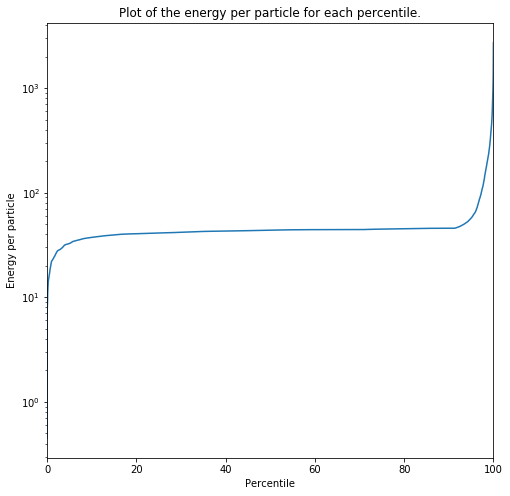

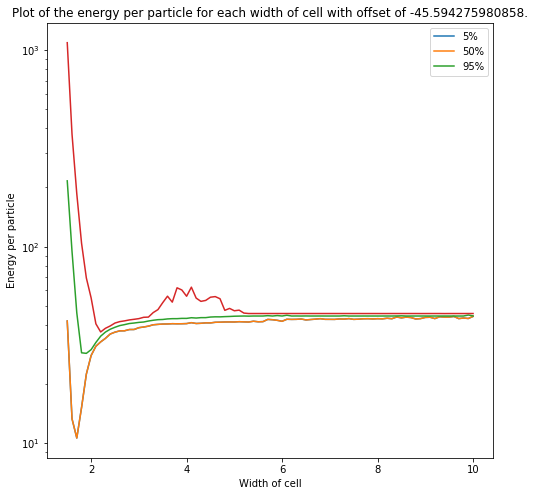

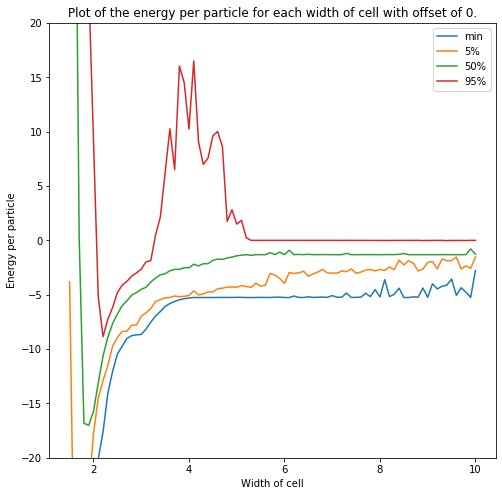

In [10]:
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset
qLow = data['potentialEnergy'].quantile(0.01)
qHi  = data['potentialEnergy'].quantile(0.99)
dataFiltered = data.copy()
#dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()


#"""
tempData = dataFiltered.copy()
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""

#"""
tempData = dataFiltered.copy()
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
plt.ylim(-2*10**1, 2*10**1)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""


data = dataFiltered

In [11]:
#data.head()

In [12]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,31521.000000,31521.000000,31521.0,31521.000000
mean,15760.000000,4.678008,3.0,4.203249
std,9099.473254,2.068157,0.0,65.557457
min,0.000000,1.500000,3.0,-45.142848
25%,7880.000000,3.000000,3.0,-4.392354
50%,15760.000000,4.500000,3.0,-1.825203
75%,23640.000000,6.100000,3.0,-0.800430
max,31520.000000,10.000000,3.0,2665.287506


In [13]:
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

def product(l):
    p = 1
    for i in l:
        p = p*i
    return p

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])#TODO remove sorted once fixed in data
    #targetData.append(trainingData['potentialEnergy'][i])
    targetData.append(sum(trainingData['eigenvalues'][i]))

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])#TODO remove sorted once fixed in data
    #targetData.append(validationData['potentialEnergy'][i])
    targetData.append(sum(validationData['eigenvalues'][i]))

validationInput = [[inputData], [targetData]]

[print(trainingInput[0][0][i], trainingInput[1][0][i], sum([abs(trainingInput[0][0][i][j]) for j in range(16)]), '\n \n') for i in range(0, 50)]

validationPlots = [random.choice(validationData.index) for i in range(0, 11)]

[-1476.2669136531, -122.0506730345, 60.8113248877, 1763.1066698933, -55652.7169751766, -1028.8714382875, 245.9434175117, 56961.8532002125, -2105915.5988045624, -8249.2570738801, 868.0391434761, 2114663.4999050754, -79940098.23011614, -65310.8600139216, 3121.0899087646, 80006023.05381854] 5853.5453796982765 164361561.249397 
 

[-76056.2187377372, -38.5273456259, 107.4650819585, 76127.96430017, -20975004.00280088, -197.7619988891, 338.5696381685, 20975146.08604685, -5784547644.9678955, -975.0987395815, 1286.1176568189, 5784547956.789896, -1595279385351.2158, -4731.8984712086, 5446.0954940495, 1595279386065.9438] 2475.340087890625 3202169982474.7236 
 

[-2325.6237041018, -62.0734512856, 30.1174707795, 2405.0889604097, -111910.7065129163, -348.2900644983, 128.2044445675, 112197.2223586056, -5390464.405192086, -1867.7497930788, 659.2211871387, 5391770.546129849, -259714289.6073866, -9954.1589195712, 3738.6152266102, 259720652.47385168] 358.87460550665855 530462804.1046538 
 

[-9116.02525

## Preparing testing

No handles with labels found to put in legend.


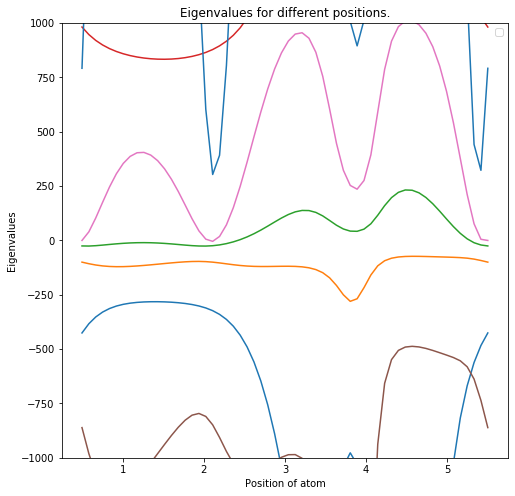

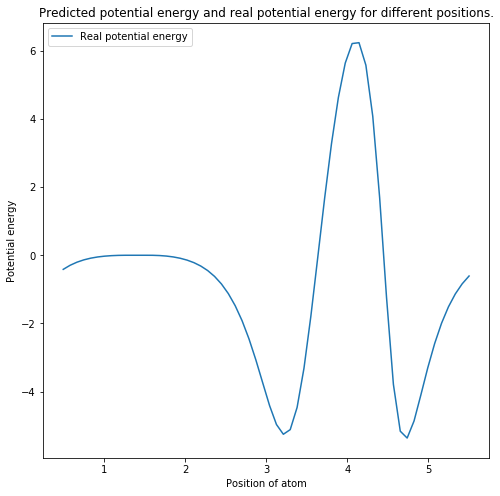

In [14]:
#"""
widthOfCell = 5.0
numberOfSurroundingCells = 3
R0 = 20
x = np.linspace(0.1, 1.1, 60)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.1, 0.1]), np.array([0.55, 0.9]), np.array([0.6, 0.665]), np.array([0.5, i])]
    #particles = [np.array([0.3, 0.5]), np.array([0.3, 0.4]), np.array([0.6, 0.4]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

#for i in range(len(x)):
#    print(testData['eigenvalues'][i])

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), [testData['eigenvalues'][i] for i in range(len(testData['eigenvalues']))])
ax1.legend()
ax1.set_ylim(-1000, 1000)
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Eigenvalues')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()

y = [[],[]]
for i in range(len(x)):
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()


#"""

# Machine learning

In [15]:
models = []

## Model 0: Linear only

In [16]:
def makeNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MSE'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3]))#, kernel_initializer=kernalInitializer))#, kernel_initializer=kernalInitializer))
    model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        if setting[0]=='Dense':# 1 is amount of nodes, 2 is kind of activation, 3 is bias
            model.add(Dense(setting[1], use_bias=setting[3]))#, kernel_initializer=kernalInitializer))
            model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)#mse or mape
    
    return model

In [17]:
settings = [['Dense', 1, 'linear', False]]
learningRate = 1*10**-3

model = makeNetwork(inputSize, settings, learningRate, 'he_uniform')#eras.initializers.glorot_uniform(seed=None)

model.summary()


newWeights = np.array([[[1] for j in range(16)]])
print(np.shape(newWeights))
print(np.shape(model.layers[0].get_weights()))
model.layers[0].set_weights(newWeights)

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 16        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
(1, 16, 1)
(1, 16, 1)
Layer 0:  [array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)]
Layer 1:  []


In [18]:
#trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
model.fit(trainingInput[0], trainingInput[1], epochs=100, verbose=1)
models.append([model, 'model0'])
print()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Epoch 1/100


InternalError:  Blas GEMV launch failed:  m=16, n=32
	 [[node dense_1/MatMul (defined at C:\Users\heisz\anaconda3\envs\BEPGPU\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_358]

Function call stack:
keras_scratch_graph


In [ ]:
#model = models[0][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()


## Model 1: 1024 wide, 1 layer

In [ ]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 1*10**-3

model = makeNetwork(inputSize, settings, learningRate, 'he_uniform')#keras.initializers.glorot_uniform(seed=None)
model.summary()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
models.append([model, 'model1'])
print()

In [ ]:
#model = models[1][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()


# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
## Model 2: 2048 wide, 1 layer

In [ ]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate, 'he_uniform')
model.summary()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model2'])
print()

In [ ]:
#model = models[2][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 3: 4096 wide, 1 layer

In [ ]:
settings = [['Dense', 4096, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model3'])
print()

In [ ]:
#model = models[3][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in validationPlots:
    plotAndPredict(model, validationData, i)

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 4: 8192 wide, 1 layer

In [ ]:
settings = [['Dense', 8192, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model4'])
print()

In [ ]:
#model = models[4][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 5: 16384 wide, 1 layer

In [ ]:
settings = [['Dense', 16384, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model5'])
print()

In [ ]:
#model = models[5][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 6: 1024 wide, 2 layer

In [ ]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model6'])
print()

In [ ]:
#model = models[6][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 7: 2048 wide, 2 layers

In [ ]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model7'])
print()

In [ ]:
#model = models[7][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 8: 1024 wide, 3 layers

In [ ]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model8'])
print()

In [ ]:
#model = models[8][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 9: 2048 wide, 3 layers

In [ ]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 2048, 'softplus', False], ['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model9'])
print()

In [ ]:
#model = models[9[0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 10: 1024 wide, 4 layers

In [ ]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model10'])
print()

In [ ]:
#model = models[10][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 11: 1024 wide, 5 layers

In [ ]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model11'])
print()

In [ ]:
#model = models[11][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Saving a model

In [ ]:
for i in range(len(models)):
    model = models[i][0]
    print(models[i][1])
    print(model.summary())
    print(model.evaluate(validationInput[0], validationInput[1], verbose=0))
    print('\n \n')

#model = models[1][0]
#model.save('model1.h5')
#model = load_model('model1.h5')